# Loads the processed h5 file and plots data
### the minimalist way (using analysis.py)

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *

In [2]:
# input parameters
run = '0126_droplets_10um_35mm'

# constants
detector_distance = 0.1249 # m
energy = 9.5 # keV

# analysis parameters
iq_thr = 0.015 # photon/pix/i0
r_min, r_max = 200,400 # bins
filter_length = 5
ice_thr = 0.1 # delta photon/pix/i0
q_min, q_max = 1.0,4.5 # A-1

### load  and analyse data

In [3]:
# load data
img,Iq,r,nshots,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

# convert intensity to photon/pix
img/=energy
Iq /=energy
i0 /=energy

# normalise to i0
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0#/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]
    
# find hits
metric,hits = find_hits(Iq_norm,threshold=iq_thr)
misses = np.logical_not(hits) & (i0[:nshots] > i0_avg - i0[:nshots].std()) # remove weak x-ray shots
hits = hits & (i0[:nshots] > i0_avg - i0[:nshots].std()) # remove weak x-ray shots
hit_rate = np.sum(hits)/nshots
# find ice hits
ice_metric,ice_hits = find_ice(Iq_norm[hits],q,threshold=ice_thr,filter_length=filter_length,q_min=q_min,q_max=q_max)
water_hits = hits.copy()
l = laser_i0[laser_on][:nshots]
laser_outliers = laser_on & ((laser_i0 > (l.mean() + l.std())) | (laser_i0 < (l.mean() - l.std())))
# find water hits
water_hits[hits] = water_hits[hits] & ~ice_hits & ~laser_outliers[hits] # remove ice shots and laser i0 outliers
if ice_hits.sum():
    print('found %d hits with >%.3f photon/pix (including %d ice hits)' % (hits.sum(), i0_avg*iq_thr, ice_hits.sum()))
else:
    print('found %d hits with >%.3f photon/pix' % (hits.sum(), i0_avg*iq_thr))

# pump probe signal
hit_avg,miss_avg,diff_signal =  pump_probe_signal(Iq,water_hits,laser_on,misses=misses,r_min=r_min,r_max=r_max)

run0069_droplets_10um_2mm: 18000 shots
found 6257 hits with >0.162 photon/pix (including 1 ice hits)


### plot

<IPython.core.display.Javascript object>


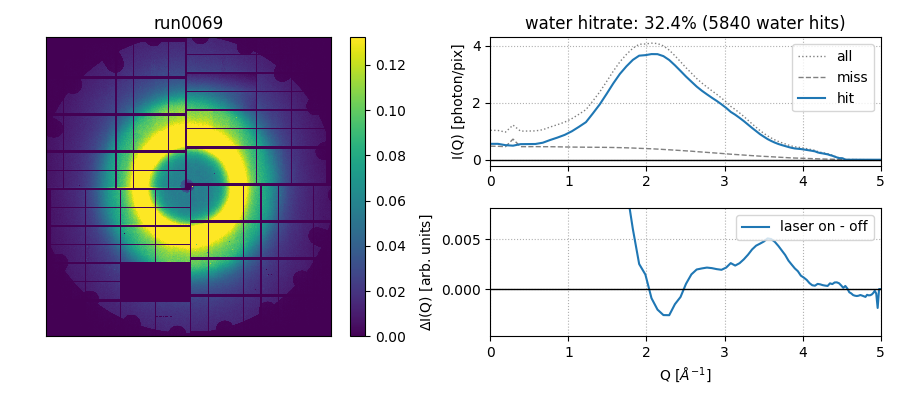

In [36]:
plt.figure(figsize=[9,4])

# 2d image
plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
#plt.imshow(img/nshots,clim=[0,0.2],origin='lower')
i = (img/nshots)
plt.imshow(i,clim=[0,i.mean()+2*i.std()],origin='lower')
plt.colorbar()
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

# radial profile
plt.subplot(2,2,2)
plt.title('water hitrate: %.1f%% (%d water hits)'%(100*water_hits.sum()/float(nshots), water_hits.sum()))
plt.plot(q, hit_avg,':',c='gray' ,lw=1,label='all')
plt.plot(q, miss_avg,'--',c='gray' ,lw=1,label='miss')
plt.plot(q, hit_avg - miss_avg, label='hit')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')

# pump probe signal
ax = plt.subplot(2,2,4)
ax.plot(q, diff_signal, label='laser on - off')
plt.ylabel('$\Delta$I(Q) [arb. units]')
#plt.ylim([-8e-3,8e-3]) #plt.figure()
s = diff_signal[20:40]
plt.ylim([s.min()-s.std(), s.max()+s.std()])
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend(loc='upper right')
plt.xlim(0,5)
plt.axhline(0,c='black',lw=1)
plt.grid(linestyle='dotted')

plt.tight_layout()
plt.savefig('run%s_diff_signal.png' % run)
plt.show()


In [37]:
choice = 'MAFF'
f_H = AFF(q, 'H', choice)
f_O = AFF(q, 'O', choice)
nominator = 1/3.*f_O*f_O + 2/3.*f_H*f_H
denominator = 1/9*(f_O + 2*f_H)**2
int_nom = np.trapz(q*q*nominator/denominator, x=q)
int_denom = np.trapz(q*q*(hit_avg-miss_avg)/denominator, x=q)
Iq_bg = hit_avg - miss_avg
norm, Sq = Iq_normalization(q, Iq_bg, nominator, q.min(), q[np.where(Iq_bg > 0)].max(), denominator=denominator, choice='la')
norm, Sq = Iq_normalization(q, Iq_bg, nominator, q.min(), q.max(), denominator=denominator, choice='int')

Large-angle normalization: 11109.30
Integral normalization: 11.40


<IPython.core.display.Javascript object>


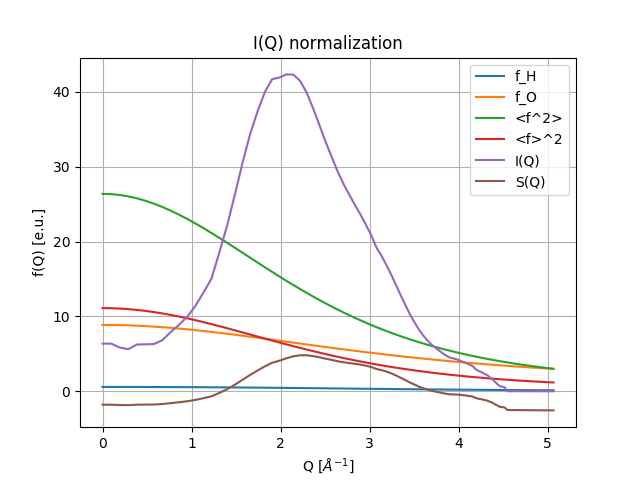

In [38]:
plt.figure()
plt.title('I(Q) normalization')
plt.plot(q, f_H, label='f_H')
plt.plot(q, f_O, label='f_O')
plt.plot(q, nominator, label='<f^2>')
plt.plot(q, denominator, label='<f>^2')
plt.plot(q, norm*(hit_avg - miss_avg), label='I(Q)')
plt.plot(q, Sq, label='S(Q)')
plt.legend()
plt.grid()
plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('f(Q) [e.u.]')
plt.show()